In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import (
    r2_score, accuracy_score, classification_report, 
    confusion_matrix, roc_curve, auc, precision_recall_curve
)
import os

FEATURES = [
    'MgFe', '[M/H]_mean_mass', '[M/H]_err_mass',
    'velDisp_ppxf_res', 'velDisp_ppxf_err_res',
    'age_mean_mass', 'age_err_mass'
]

MODEL_PARAMS = {
    'max_depth': 22,
    'max_features': 0.793,
    'max_samples': 0.500,
    'min_samples_leaf': 1,
    'min_samples_split': 4,
    'n_estimators': 460,
    'random_state': 42
}

In [20]:
def evaluate_regression(df, n_splits=5):
    print(f"\nRunning {n_splits}-fold cross validation for regression...")
    
    X = df[FEATURES]
    y = df['DoR']
    
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    scaler = StandardScaler()
    rf_model = RandomForestRegressor(**MODEL_PARAMS)
    
    scores = []
    for fold, (train_idx, test_idx) in enumerate(kf.split(X), 1):
        # Prepare and scale data
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        
        # Train and evaluate
        rf_model.fit(X_train_scaled, y_train)
        y_pred = rf_model.predict(X_test_scaled)
        r2 = r2_score(y_test, y_pred)
        scores.append(r2)
        
        print(f"Fold {fold}/{n_splits} - R²: {r2:.4f}")
    
    print(f"\nMean R²: {np.mean(scores):.4f} (±{np.std(scores):.4f})")
    return scores

In [21]:

def evaluate_classification(df, n_splits=5, split_threshold=0.6):
    """Run classification analysis with k-fold cross validation"""
    print(f"\nRunning {n_splits}-fold classification...")
    
    X = df[FEATURES]
    y = (df['DoR'] > split_threshold).astype(int)
    class_names = [f'DoR ≤ {split_threshold}', f'DoR > {split_threshold}']
    
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    scaler = StandardScaler()
    clf = RandomForestClassifier(**MODEL_PARAMS)
    
    results = {
        'accuracies': [], 'confusion_matrices': [],
        'classification_reports': [], 'roc_aucs': [], 'feature_importance':[]
    }
    
    for fold, (train_idx, test_idx) in enumerate(kf.split(X), 1):
        # Prepare and scale data
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        
        # Train and evaluate
        clf.fit(X_train_scaled, y_train)
        y_pred = clf.predict(X_test_scaled)
        y_pred_proba = clf.predict_proba(X_test_scaled)[:, 1]
        
        # Store results
        results['accuracies'].append(accuracy_score(y_test, y_pred))
        results['confusion_matrices'].append(confusion_matrix(y_test, y_pred))
        results['classification_reports'].append(
            classification_report(y_test, y_pred, target_names=class_names)
        )
        results['feature_importance'].append(
            dict(zip(FEATURES, clf.feature_importances_))
        )
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
        results['roc_aucs'].append(auc(fpr, tpr))
        
        print(f"\nFold {fold}/{n_splits}")
        print(results['classification_reports'][-1])
    
    # Plot average confusion matrix
    avg_cm = np.mean(results['confusion_matrices'], axis=0) / (0.2 * len(df)) * 100
    plt.figure(figsize=(8, 6))
    sns.heatmap(
        avg_cm, annot=True, fmt='.1f', cmap='Blues',
        xticklabels=class_names, yticklabels=class_names
    )
    plt.title('Average Confusion Matrix Across All Folds')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()
    
    mean_importance = pd.DataFrame(results['feature_importance']).mean()
    plt.figure(figsize=(10, 6))
    mean_importance.sort_values().plot(kind='barh')
    plt.title('Mean Feature Importance Across All Folds')
    plt.xlabel('Mean Importance')
    plt.tight_layout()
    plt.show()
    
    return results

In [22]:
def export_dor_groups(df, output_path, small_boundary=0.4, large_boundary=0.55, csv_name='DoR_Groups.csv' ):
    """Export DoR groups to CSV"""
    os.makedirs(output_path, exist_ok=True)
    
    # Create SDSS identifiers
    sdss_ids = [
        f"spec-{int(plate):04d}-{int(mjd):05d}-{int(fiber):04d}.fits" 
        for plate, mjd, fiber in zip(df['plate'], df['mjd'], df['fiberid'])
    ]
    
    # Create labels
    labels = pd.Series(1, index=df.index)  # middle group
    labels[df['DoR'] <= small_boundary] = 0  # small group
    labels[df['DoR'] >= large_boundary] = 2  # large group
    
    # Save results
    results_df = pd.DataFrame({'SDSS_ID': sdss_ids, 'Cluster': labels})
    filename = os.path.join(output_path, csv_name)
    results_df.to_csv(filename, index=False)
    
    print(f"Saved DoR groups to {filename}")
    print("Group sizes:")
    print(f"DoR <= {small_boundary}: {sum(labels == 0)}")
    print(f"{small_boundary} < DoR < {large_boundary}: {sum(labels == 1)}")
    print(f"DoR >= {large_boundary}: {sum(labels == 2)}")



Running 5-fold cross validation for regression...
Fold 1/5 - R²: 0.8085
Fold 2/5 - R²: 0.7963
Fold 3/5 - R²: 0.8008
Fold 4/5 - R²: 0.8124
Fold 5/5 - R²: 0.8323

Mean R²: 0.8100 (±0.0125)

Running 5-fold classification...

Fold 1/5
              precision    recall  f1-score   support

   DoR ≤ 0.6       0.90      0.95      0.93        66
   DoR > 0.6       0.81      0.65      0.72        20

    accuracy                           0.88        86
   macro avg       0.86      0.80      0.82        86
weighted avg       0.88      0.88      0.88        86


Fold 2/5
              precision    recall  f1-score   support

   DoR ≤ 0.6       0.96      0.99      0.97        72
   DoR > 0.6       0.92      0.79      0.85        14

    accuracy                           0.95        86
   macro avg       0.94      0.89      0.91        86
weighted avg       0.95      0.95      0.95        86


Fold 3/5
              precision    recall  f1-score   support

   DoR ≤ 0.6       0.97      0.93      

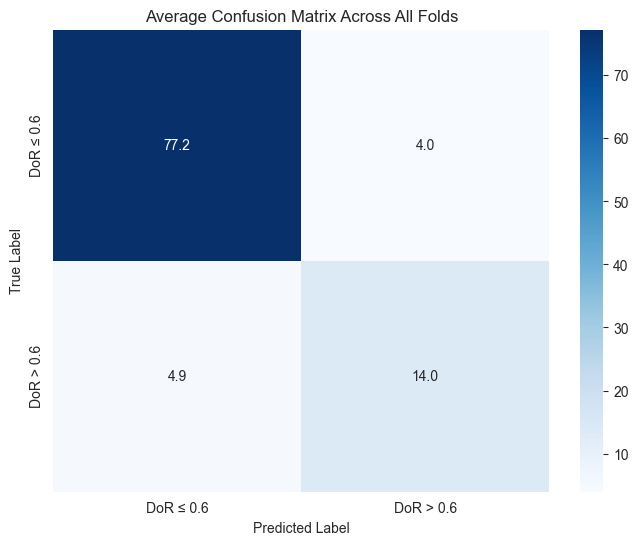

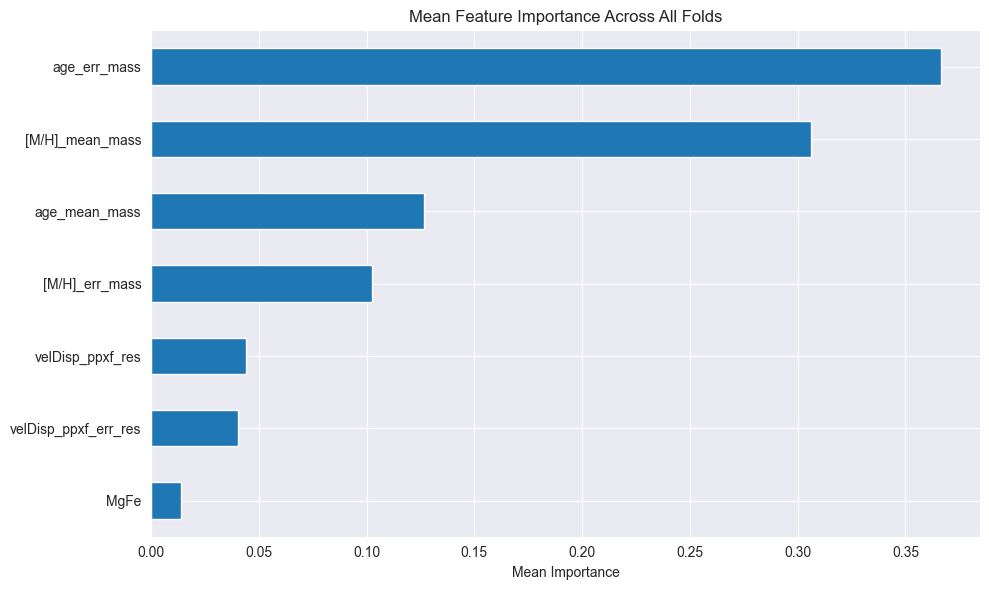

Saved DoR groups to ../data/cluster_results/DoR_Groups.csv
Group sizes:
DoR <= 0.3: 56
0.3 < DoR < 0.6: 293
DoR >= 0.6: 81


In [23]:

filepath = '../data/E-INSPIRE_I_master_catalogue.csv'
output_path = '../data/cluster_results'
csv_name = 'DoR_Groups.csv'

df = pd.read_csv(filepath)

# Run regression analysis
reg_results = evaluate_regression(df, n_splits=5)

# Run classification analysis
class_results = evaluate_classification(df, n_splits=5, split_threshold=0.6)

# Export groups
export_dor_groups(df,small_boundary=0.3, large_boundary=0.6, output_path=output_path, csv_name=csv_name)